# "Who's the author of this paper?": A Data Literacy Project

## The Question
The highest-level, originating question is *"Can we identify the author of a paper from its contents?"*. This question lacks specificity in:
1. the *identification* process (how likely is X as author given the text?, binary classification, multinomial classification)
2. the *authorship* criteria (only first authors? any author? all authors except last authors?)
3. the *contents* of the paper (word statistics, sentence statistics, structural statistics, topics...)

To answer these questions, the authors have decided to use one of the prominent, freely accessible academic databases of our times: _arXiv_.

## The Dataset
_arXiv_ is a freely accessible, online repository of academic works spanning Physics, Mathematics, Computer Science, Statistics, Electrical Engineering and Economics. Papers (or _e-prints_) are described by a Title, an Id, Publishing Date, Updates Dates, a Summary, one or more Authors, a Category and the relative latex sourcecode (when available).

To answer the original question, we take the following assumptions:
1. only _first-authors_ are considered valid _authors_;
2. we consider only the (de-latex-fied) corpus of text;

To enrich the paper entries with additional metadata, we query _OpenAlex_ and _CrossRef_, specifically: first author's Institution, first author's Country, coauthors' Countries, Venue, Venue ISSN, Publication Year, Citations, Bibliography and relative metadata.

We consider data.

In [49]:
import pandas as pd
import numpy as np
import json
import os

# First Inquiry - Word Frequence
First we are going to specify an interpretation of the question:
> *"Can we identify the author of a paper from its contents?"*

We consider only _first-authorships_, and _similarity statistics_ based on _word frequency_.

## Loading the Data

In [50]:
def load_word_features(arxiv_id, folder_path='.'):
    filename = f'{arxiv_id}_features.json'
    filepath = os.path.join(folder_path, filename)

    try:
        with open(filepath, 'r') as f:
            data = json.load(f)

        # Extract features (exclude sentence_lengths list)
        features = {
            'total_sentences': data.get('total_sentences'),
            'pruned_sentences': data.get('pruned_sentences'),
            'total_words': data.get('total_words'),
            'pruned_words': data.get('pruned_words'),
            'unique_words': data.get('unique_words'),
            'mean_sentence_length': data.get('mean_sentence_length'),
            'stdev_sentence_length': data.get('stdev_sentence_length'),
            'vocabulary_size': data.get('vocabulary_size')
        }
        return features
    except FileNotFoundError:
        # Return None values if file doesn't exist
        return {key: None for key in ['total_sentences', 'pruned_sentences', 'total_words',
                                       'pruned_words', 'unique_words', 'mean_sentence_length',
                                       'stdev_sentence_length', 'vocabulary_size']}

In [67]:
# Setup Dataframe
metadata_path = 'data/metadata.csv'
# Creating Dataframe from completed metadata.csv
df = pd.read_csv(metadata_path, delimiter=',')
print("There are ", len(df), " rows.")

# Selecting only the currently relevant columns
df = df[['arxiv_id','first_author','primary_category', 'first_author_country']]
print(f"There are", len(df.first_author.unique()), " unique authors.")
print(f"\t", df.first_author.unique())
print(f"There are", len(df.first_author.unique()), " unique categories.")
print(f"\t", df.primary_category.unique())

# Loading word frequency features
word_features_path = 'data/features'
features_df = df['arxiv_id'].apply(lambda x: pd.Series(load_word_features(x, word_features_path)))
df = pd.concat([df, features_df], axis=1)
print(df.head())

# Cleaning Dataframe from NaN entries
feature_columns = features_df.columns.tolist()
df = df.dropna(subset=feature_columns, how='all')
print(df.head())
print(f"Rows after removing all-NaN features: {len(df)}")
print(f"There are", len(df.first_author.unique()), " unique authors.")
print(f"\t", df.first_author.unique())
print(f"There are", len(df.first_author.unique()), " unique categories.")
print(f"\t", df.primary_category.unique())

word_freq_path = 'data/word_freq_data.csv'
df.to_csv(word_freq_path, index=False)

There are  1000  rows.
There are 42  unique authors.
	 ['Tao Sun' 'Maciej Skorski' 'Ilias Diakonikolas' 'Daniel M. Kane'
 'Daniel M Kane' 'Mingyi Hong' 'Song-Nam Hong' 'Frank Nielsen'
 'Thomas Y. Hou' 'Thomas Y Hou' 'Thomas Y. hou' 'Victor Chernozhukov'
 'Rahul Singh' 'Arnab Bhattacharyya' 'Aryan Mokhtari' 'Zeyuan Allen-Zhu'
 'Dan Alistarh' 'Vladimir Vovk' 'Yichen Zhang' 'Huy Phan' 'Trong Huy Phan'
 'Anh-Huy Phan' 'Anh Huy Phan' 'Anirban Biswas' 'Jie Ding' 'Chao Gao'
 'Jonathan Scarlett' 'Vitaly Feldman' 'Xiao Mao' 'Xiao Ma'
 'Christian Beck' 'Martin Hutzenthaler' 'Song Fang' 'Alina Ene' 'Dan Liu'
 'Vincent Cohen-Addad' 'Yongxin Chen' 'Niraj Kumar' 'Niraj Kumar Singh'
 'Krzysztof Choromanski' 'Nathan Kallus' 'Bo Feng']
There are 42  unique categories.
	 ['physics.med-ph' 'math.OC' 'cs.CV' 'stat.ME' 'physics.chem-ph' 'math.NA'
 'cond-mat.supr-con' 'cond-mat.str-el' 'cs.LG' 'math.ST' 'cs.IT' 'cs.DS'
 'math.PR' 'cs.SC' 'stat.OT' 'cs.CR' 'cs.GT' 'cs.CC' 'cs.DC' 'quant-ph'
 'cs.CG' 'math.NT

## Visualize Differences

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [53]:
# Group by author and explore
author_stats = df.groupby('first_author')[features].mean()
print(author_stats)

print("\nPapers per author:")
print(df['first_author'].value_counts())

                       mean_sentence_length  vocabulary_size  unique_words
first_author                                                              
Alina Ene                         21.005950       783.650000    783.650000
Anh Huy Phan                      20.656442       523.000000    523.000000
Anh-Huy Phan                      18.134657       629.800000    629.800000
Anirban Biswas                     5.935662       311.227273    311.227273
Arnab Bhattacharyya               20.362325       893.136364    893.136364
Aryan Mokhtari                    24.919446       744.523810    744.523810
Bo Feng                           10.615465       470.000000    470.000000
Chao Gao                          20.754366      1224.878788   1224.878788
Christian Beck                    29.400539       775.666667    775.666667
Dan Alistarh                      27.706538      1185.523810   1185.523810
Dan Liu                           18.094852       824.812500    824.812500
Daniel M Kane            

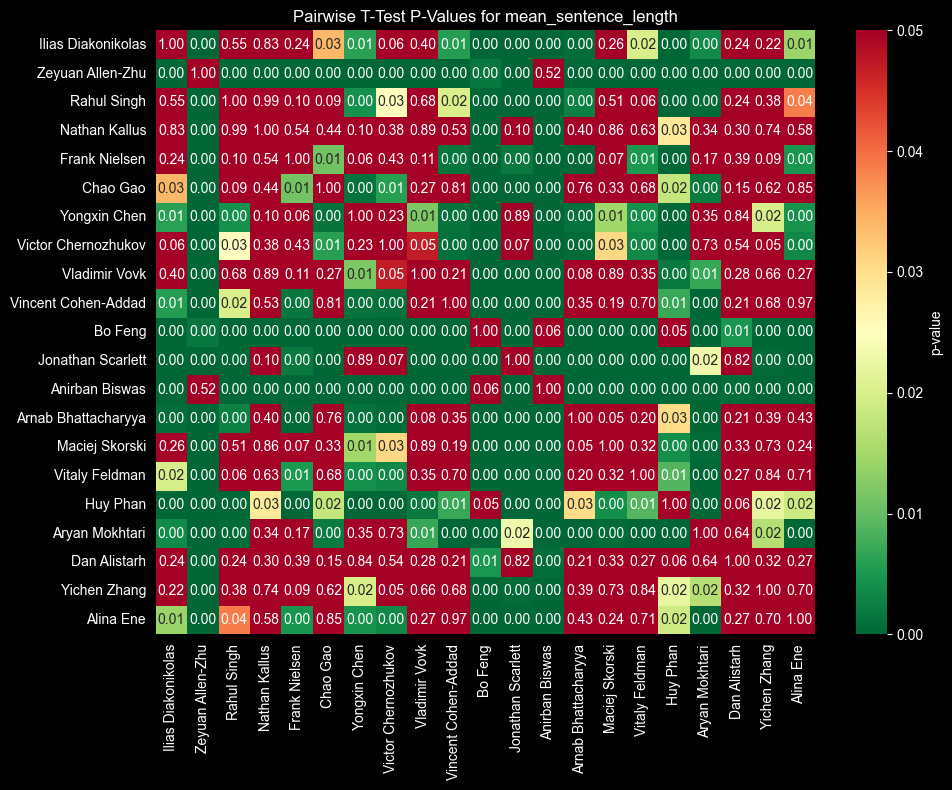


mean_sentence_length:
                     Ilias Diakonikolas  Zeyuan Allen-Zhu   Rahul Singh  \
Ilias Diakonikolas         1.000000e+00      1.207349e-35  5.464598e-01   
Zeyuan Allen-Zhu           1.207349e-35      1.000000e+00  3.250935e-33   
Rahul Singh                5.464598e-01      3.250935e-33  1.000000e+00   
Nathan Kallus              8.318681e-01      3.680255e-13  9.883200e-01   
Frank Nielsen              2.372790e-01      1.085908e-30  9.737416e-02   
Chao Gao                   3.406662e-02      9.035419e-21  8.624754e-02   
Yongxin Chen               6.237488e-03      1.497611e-21  4.391721e-03   
Victor Chernozhukov        5.962503e-02      3.597521e-26  2.517637e-02   
Vladimir Vovk              3.963614e-01      2.645864e-24  6.830092e-01   
Vincent Cohen-Addad        5.747476e-03      5.670895e-25  1.992367e-02   
Bo Feng                    1.004887e-11      1.681129e-03  1.753567e-10   
Jonathan Scarlett          9.364125e-07      1.743466e-30  5.100140e-08   
An

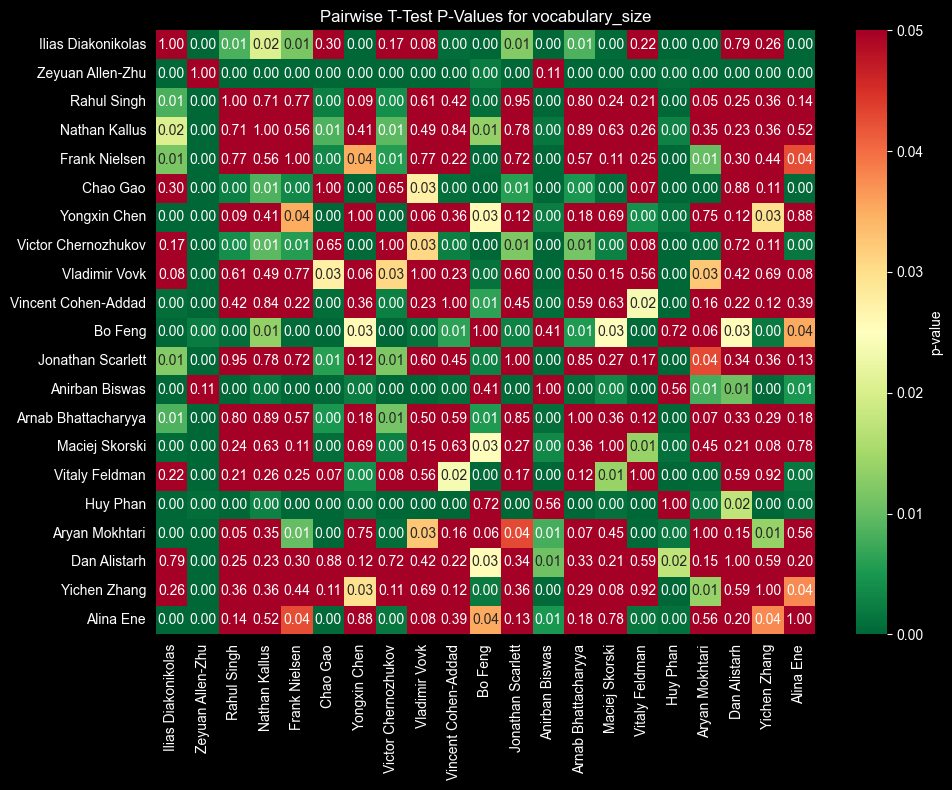


vocabulary_size:
                     Ilias Diakonikolas  Zeyuan Allen-Zhu   Rahul Singh  \
Ilias Diakonikolas         1.000000e+00      1.604807e-25  8.387203e-03   
Zeyuan Allen-Zhu           1.604807e-25      1.000000e+00  2.543626e-18   
Rahul Singh                8.387203e-03      2.543626e-18  1.000000e+00   
Nathan Kallus              2.041513e-02      2.613759e-10  7.080753e-01   
Frank Nielsen              1.169935e-02      3.293611e-21  7.711753e-01   
Chao Gao                   2.992111e-01      3.329501e-20  2.520943e-03   
Yongxin Chen               3.792984e-05      5.375622e-14  9.367473e-02   
Victor Chernozhukov        1.733903e-01      2.577191e-15  4.085201e-03   
Vladimir Vovk              7.913104e-02      1.205859e-15  6.131573e-01   
Vincent Cohen-Addad        7.782525e-04      4.563198e-17  4.171816e-01   
Bo Feng                    4.092235e-07      1.994873e-03  6.140212e-04   
Jonathan Scarlett          1.237300e-02      6.002852e-17  9.479407e-01   
Anirban

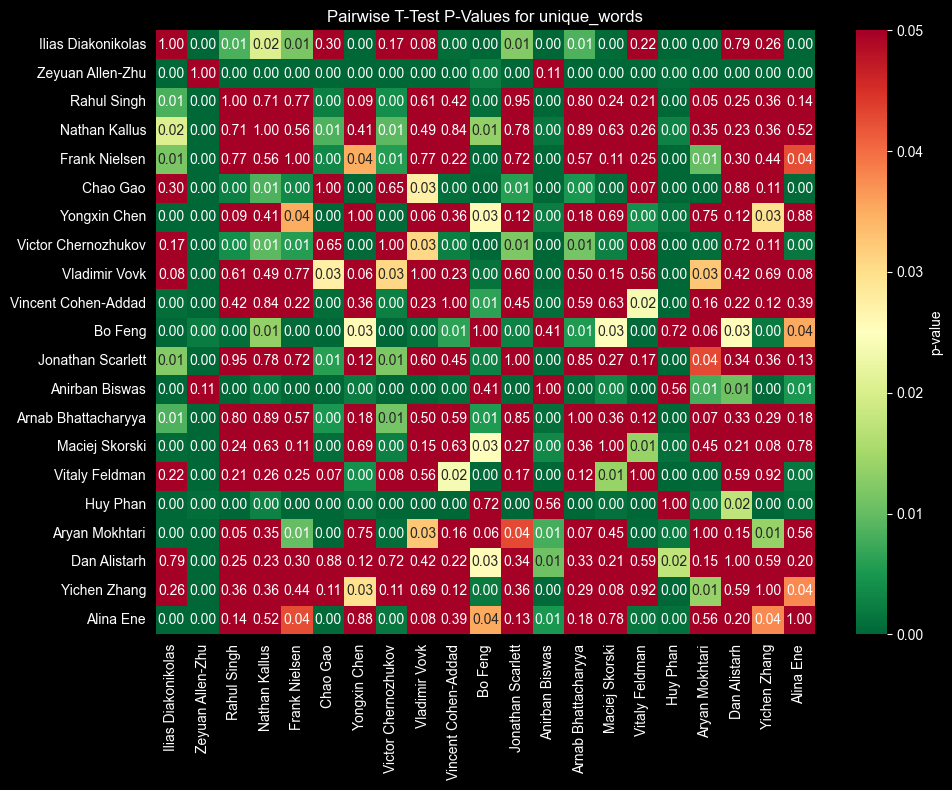


unique_words:
                     Ilias Diakonikolas  Zeyuan Allen-Zhu   Rahul Singh  \
Ilias Diakonikolas         1.000000e+00      1.604807e-25  8.387203e-03   
Zeyuan Allen-Zhu           1.604807e-25      1.000000e+00  2.543626e-18   
Rahul Singh                8.387203e-03      2.543626e-18  1.000000e+00   
Nathan Kallus              2.041513e-02      2.613759e-10  7.080753e-01   
Frank Nielsen              1.169935e-02      3.293611e-21  7.711753e-01   
Chao Gao                   2.992111e-01      3.329501e-20  2.520943e-03   
Yongxin Chen               3.792984e-05      5.375622e-14  9.367473e-02   
Victor Chernozhukov        1.733903e-01      2.577191e-15  4.085201e-03   
Vladimir Vovk              7.913104e-02      1.205859e-15  6.131573e-01   
Vincent Cohen-Addad        7.782525e-04      4.563198e-17  4.171816e-01   
Bo Feng                    4.092235e-07      1.994873e-03  6.140212e-04   
Jonathan Scarlett          1.237300e-02      6.002852e-17  9.479407e-01   
Anirban Bi

In [54]:
####### CHIEDI A CLAUDIO SE E GIUSTI IL T_TEST FATT ACCUSI
# Compare word statistics

# Get top authors with enough samples
min_papers = 20  # Adjust as needed
author_counts = df['first_author'].value_counts()
top_authors = author_counts[author_counts >= min_papers].index.tolist()

# Create pairwise p-value matrix for a feature
def create_pvalue_matrix(df, authors, feature):
    n = len(authors)
    pvalue_matrix = np.zeros((n, n))

    for i, author1 in enumerate(authors):
        for j, author2 in enumerate(authors):
            if i == j:
                pvalue_matrix[i, j] = 1.0  # Same author
            else:
                data1 = df[df['first_author'] == author1][feature].dropna()
                data2 = df[df['first_author'] == author2][feature].dropna()

                if len(data1) > 1 and len(data2) > 1:
                    _, p_val = stats.ttest_ind(data1, data2)
                    pvalue_matrix[i, j] = p_val
                else:
                    pvalue_matrix[i, j] = np.nan

    return pd.DataFrame(pvalue_matrix, index=authors, columns=authors)

# List of features to analyze
features = ['mean_sentence_length', 'vocabulary_size', 'unique_words']

# Create and visualize p-value matrix for each feature
for feature in features:
    pvalue_df = create_pvalue_matrix(df, top_authors, feature)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pvalue_df, annot=True, fmt='.2f', cmap='RdYlGn_r',
                cbar_kws={'label': 'p-value'}, vmin=0, vmax=0.05)
    plt.title(f'Pairwise T-Test P-Values for {feature}')
    plt.tight_layout()
    plt.show()

    print(f"\n{feature}:")
    print(pvalue_df)


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data
feature_list = ['mean_sentence_length', 'stdev_sentence_length',
                'vocabulary_size', 'pruned_words', 'unique_words']

# Filter to top authors and remove NaN
df_filtered = df[df['first_author'].isin(top_authors)].dropna(subset=feature_list)

# Method 1: Classification Accuracy per Feature
print("=== Individual Feature Classification Accuracy ===\n")
accuracy_scores = {}

for feature in feature_list:
    X = df_filtered[[feature]].values
    y = df_filtered['first_author'].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-validation with Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')

    accuracy_scores[feature] = scores.mean()
    print(f"{feature}: {scores.mean():.3f} (+/- {scores.std():.3f})")

# Method 2: Average P-value (lower = better discrimination)
print("\n=== Average P-value Across All Author Pairs ===\n")
avg_pvalues = {}

for feature in feature_list:
    pvalue_df = create_pvalue_matrix(df_filtered, top_authors, feature)
    # Get upper triangle (excluding diagonal) to avoid duplicate pairs
    mask = np.triu(np.ones_like(pvalue_df, dtype=bool), k=1)
    avg_pval = pvalue_df.where(mask).stack().mean()

    avg_pvalues[feature] = avg_pval
    print(f"{feature}: {avg_pval:.6f}")

# Method 3: Percentage of Significant Pairs (p < 0.05)
print("\n=== Percentage of Significantly Different Author Pairs ===\n")
sig_percentages = {}

for feature in feature_list:
    pvalue_df = create_pvalue_matrix(df_filtered, top_authors, feature)
    mask = np.triu(np.ones_like(pvalue_df, dtype=bool), k=1)
    pvalues = pvalue_df.where(mask).stack()

    sig_percent = (pvalues < 0.05).sum() / len(pvalues) * 100
    sig_percentages[feature] = sig_percent
    print(f"{feature}: {sig_percent:.1f}%")

# Summary ranking
print("\n=== Feature Ranking (Best to Worst) ===\n")
print("By Classification Accuracy:")
for feat, score in sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feat}: {score:.3f}")

print("\nBy Discrimination Power (% significant pairs):")
for feat, pct in sorted(sig_percentages.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feat}: {pct:.1f}%")


=== Individual Feature Classification Accuracy ===

mean_sentence_length: 0.193 (+/- 0.023)
stdev_sentence_length: 0.174 (+/- 0.023)
vocabulary_size: 0.162 (+/- 0.055)
pruned_words: 0.153 (+/- 0.065)
unique_words: 0.162 (+/- 0.055)

=== Average P-value Across All Author Pairs ===

mean_sentence_length: 0.174723
stdev_sentence_length: 0.165771
vocabulary_size: 0.187019
pruned_words: 0.187995
unique_words: 0.187019

=== Percentage of Significantly Different Author Pairs ===

mean_sentence_length: 58.6%
stdev_sentence_length: 52.4%
vocabulary_size: 54.8%
pruned_words: 54.8%
unique_words: 54.8%

=== Feature Ranking (Best to Worst) ===

By Classification Accuracy:
  mean_sentence_length: 0.193
  stdev_sentence_length: 0.174
  vocabulary_size: 0.162
  unique_words: 0.162
  pruned_words: 0.153

By Discrimination Power (% significant pairs):
  mean_sentence_length: 58.6%
  vocabulary_size: 54.8%
  pruned_words: 54.8%
  unique_words: 54.8%
  stdev_sentence_length: 52.4%


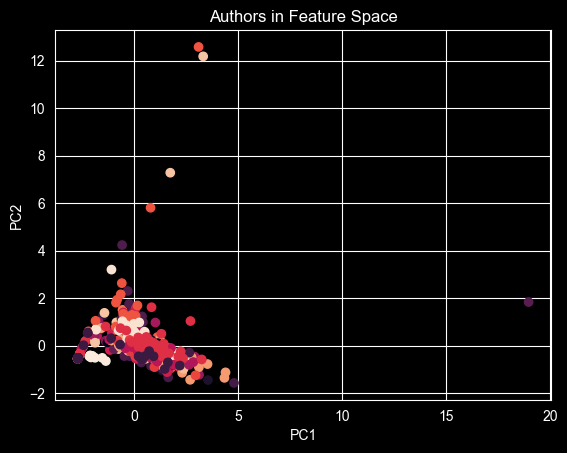

In [61]:
# Select numeric features
features = ['mean_sentence_length',
            'vocabulary_size', 'unique_words']

# Standardize features
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization - FIX HERE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Changed from transform to fit_transform

# Plot by author
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df.loc[X.index, 'first_author'].astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Authors in Feature Space')
plt.show()

Top 20 authors:
  US: 46 papers
  CN: 32 papers
  IN: 24 papers
  GB: 21 papers
  DE: 17 papers
  JP: 15 papers
  FR: 4 papers
  CH: 3 papers
  AT: 2 papers
  SG: 2 papers
  AU: 1 papers
  BE: 1 papers


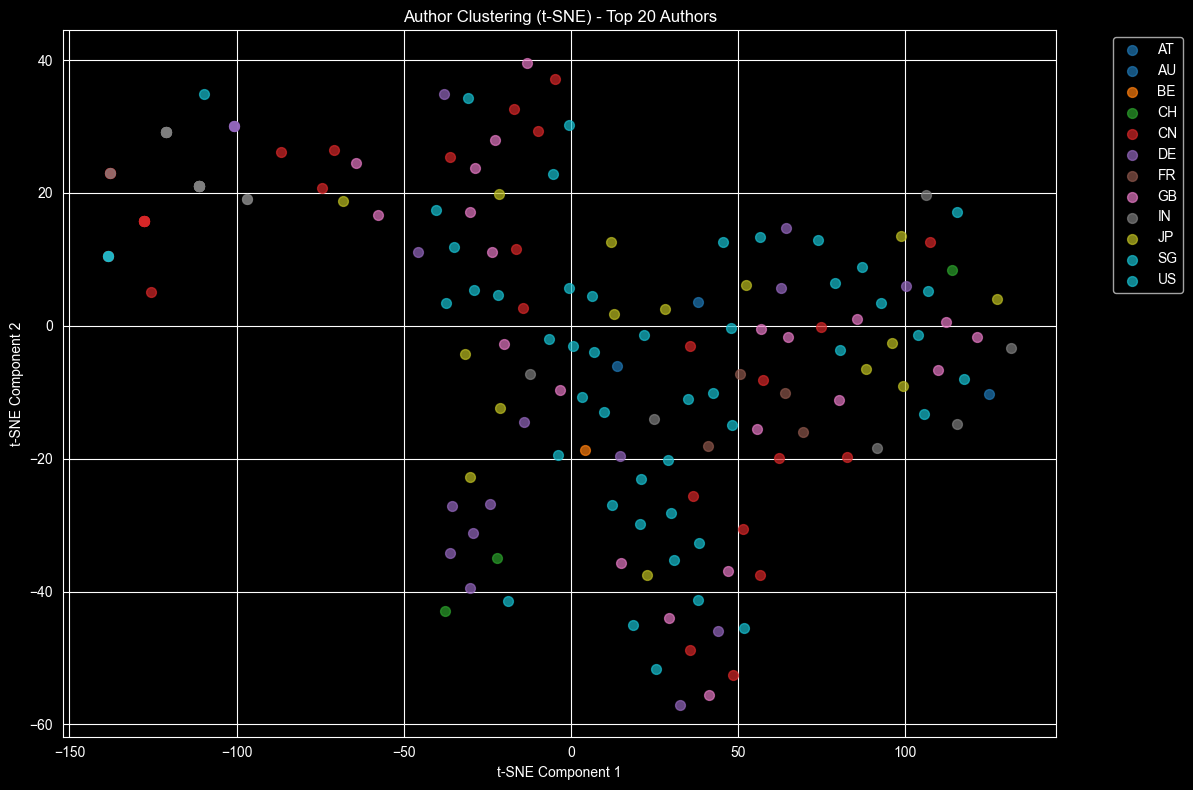


Total papers visualized: 168


In [68]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

target_column = 'first_author_country'
# Select top X authors by paper count
X_top = 20  # Change this number to include more/fewer authors
top_authors_list = df[target_column].value_counts().head(X_top).index.tolist()

print(f"Top {X_top} authors:")
for author in top_authors_list:
    count = (df[target_column] == author).sum()
    print(f"  {author}: {count} papers")

# Select numeric features
features = ['mean_sentence_length',
            'vocabulary_size', 'unique_words']

# Prepare data (filter to top authors and remove NaN)
df_filtered = df[df[target_column].isin(top_authors_list)].dropna(subset=features)
X = df_filtered[features].values
authors = df_filtered[target_column].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
unique_authors = np.unique(authors)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_authors)))

for i, author in enumerate(unique_authors):
    mask = authors == author
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=[colors[i]], label=author, alpha=0.7, s=50)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f'Author Clustering (t-SNE) - Top {X_top} Authors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nTotal papers visualized: {len(df_filtered)}")
